Charging strategy: MARKET
Strategy status:   ACTIVE
Verwendetes Szenario: office
Vorhandene Ladepunkte am Standort: 20
Erster Timestamp: 2025-12-01 00:00:00
Letzter Timestamp: 2025-12-14 23:45:00
Simulationshorizont: 14 Tage
Kalenderische Tage je Tagtyp:
- working_day: 10 Tage
- saturday: 2 Tage
- sunday_holiday: 2 Tage

Anzahl Ladesessions im Simulationshorizont: 1033
Max. gleichzeitig ladende Fahrzeuge: 20

Beispiel-Sessions (erste 10):
Fahrzeug: iX xDrive50, Ankunft: 2025-12-01 05:54:42.336072, Abfahrt: 2025-12-01 06:43:03.150270, Kapazität: 110.0 kWh, geladene Energie: 12.7 kWh, Restbedarf: 0.0 kWh
Fahrzeug: CLA, Ankunft: 2025-12-01 05:58:25.917147, Abfahrt: 2025-12-01 06:49:10.758827, Kapazität: 58.0 kWh, geladene Energie: 19.7 kWh, Restbedarf: 0.0 kWh
Fahrzeug: Mokka e, Ankunft: 2025-12-01 06:36:03.398915, Abfahrt: 2025-12-01 13:25:19.471586, Kapazität: 50.0 kWh, geladene Energie: 6.1 kWh, Restbedarf: 0.0 kWh
Fahrzeug: Macan, Ankunft: 2025-12-01 06:44:27.254544, Abfahrt: 2025-12-

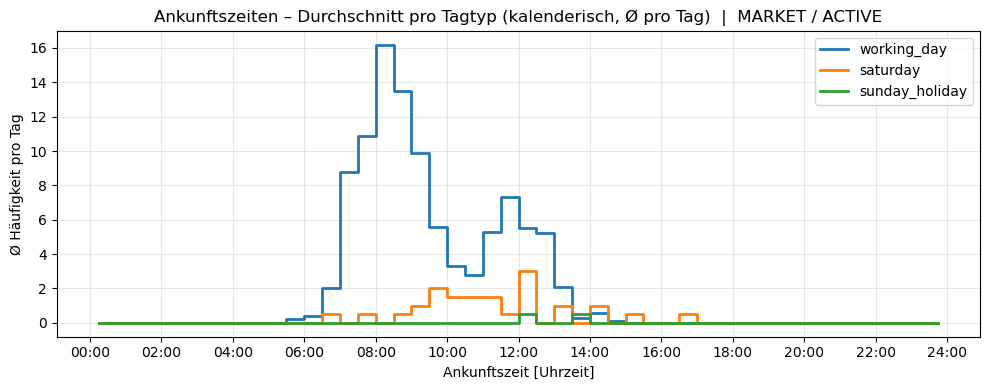

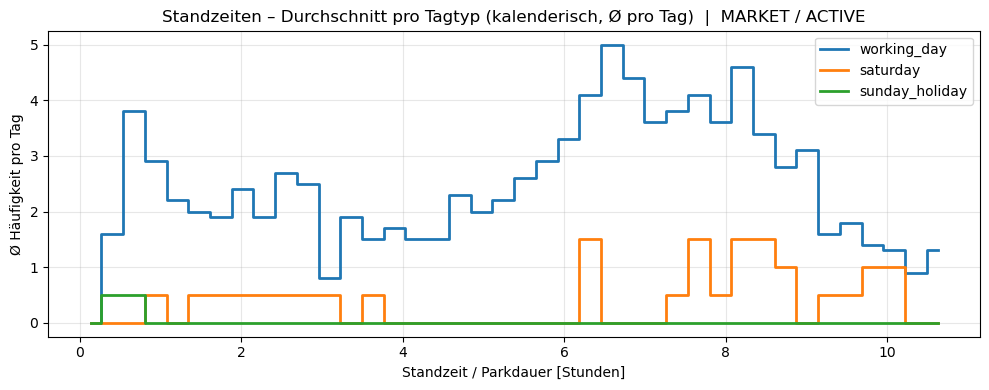

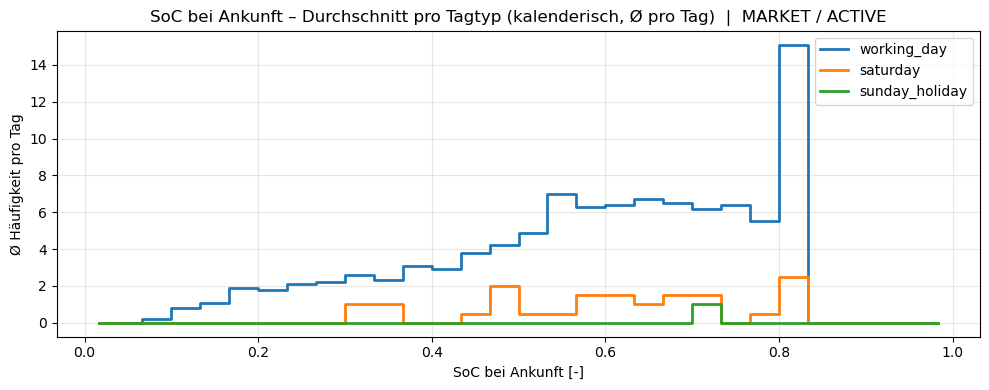

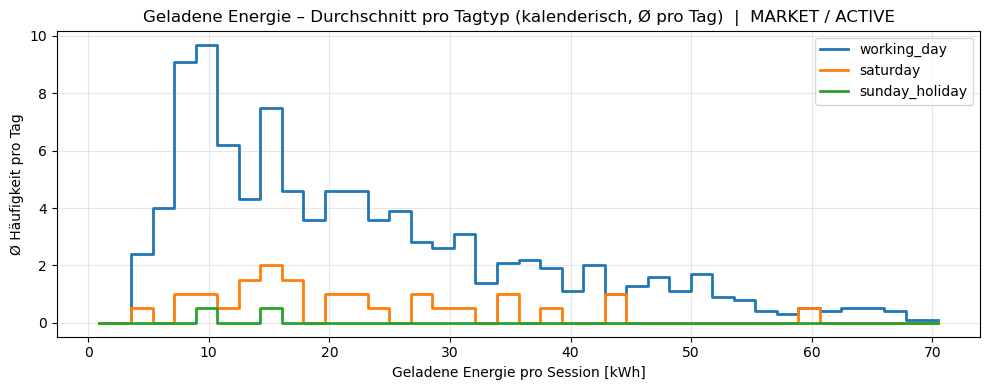

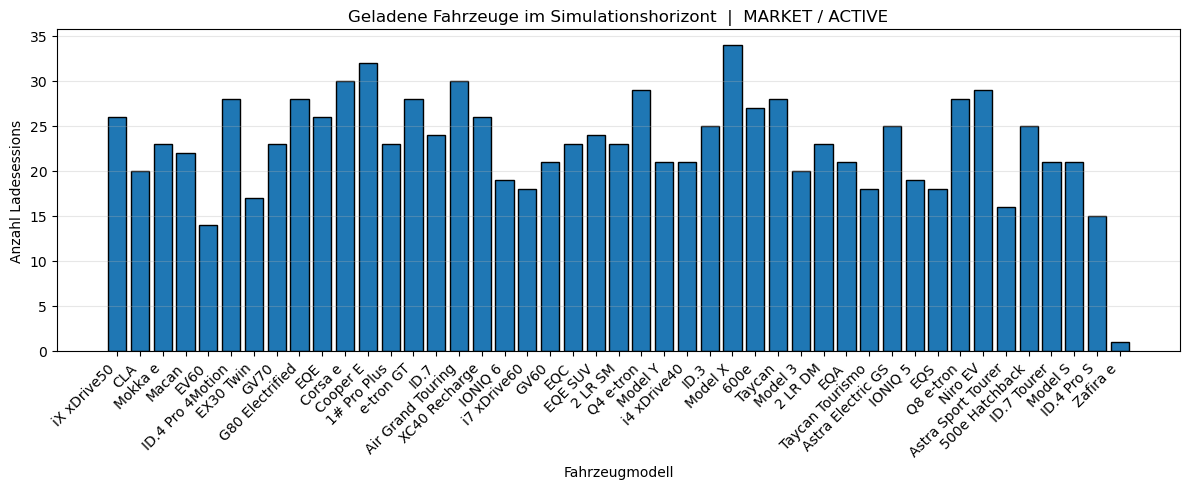

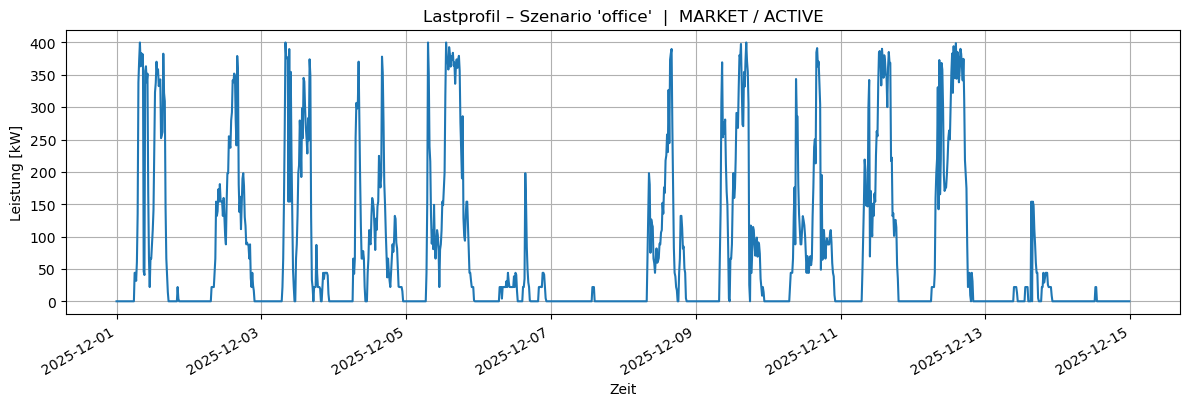

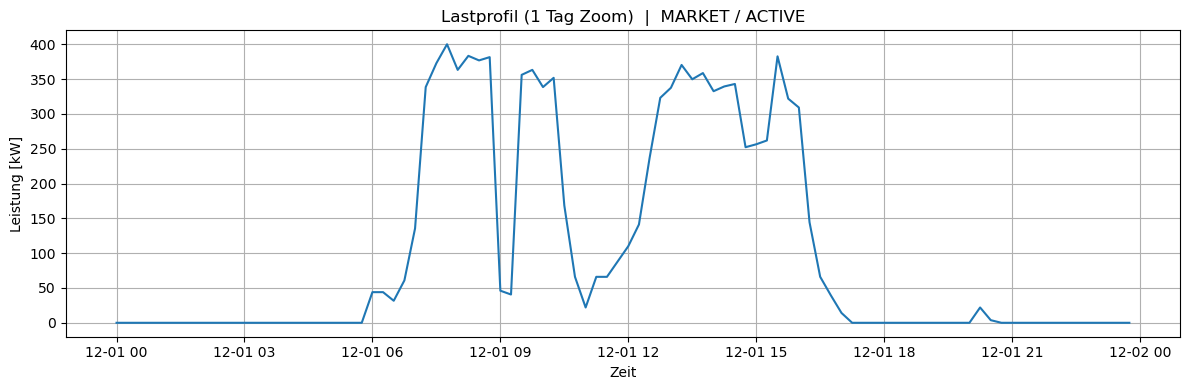

In [2]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import warnings
from collections import Counter
from collections import defaultdict
from datetime import datetime, timedelta, date

# ✅ Warnungen im Notebook immer anzeigen (z.B. CSV deckt Zeitraum nicht ab)
warnings.simplefilter("always", UserWarning)

# ✅ HTML-Ausgabe für farbige Statuszeile
from IPython.display import display, HTML


# =============================================================================
# 0) Notebook-UI Helpers (Lösung 1)
# =============================================================================

def show_strategy_status_html(charging_strategy: str, strategy_status: str) -> None:
    """
    Farbiges Status-Badge im Notebook.
    Emojis sind nur hier erlaubt (HTML), damit Matplotlib keine Glyph-Warnungen wirft.
    """
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()

    color_map = {
        "ACTIVE": "#1a7f37",
        "PARTIAL": "#b58100",
        "INACTIVE": "#c62828",
        "IMMEDIATE": "#616161",
    }
    emoji_map = {
        "ACTIVE": "🟢",
        "PARTIAL": "🟡",
        "INACTIVE": "🔴",
        "IMMEDIATE": "⚪",
    }

    color = color_map.get(status, "#616161")
    emoji = emoji_map.get(status, "⚪")

    html = f"""
    <div style="
        font-size:18px; font-weight:800; color:{color};
        padding:10px 12px; border:2px solid {color};
        border-radius:12px; display:flex; align-items:center;
        gap:10px; width:fit-content; margin:8px 0 14px 0;
        background: rgba(0,0,0,0.02);
    ">
      <span style="font-size:22px">{emoji}</span>
      <div>
        <div>Charging strategy: <span style="letter-spacing:0.5px">{strat}</span></div>
        <div>Strategy status: <span style="letter-spacing:0.5px">{status}</span></div>
      </div>
    </div>
    """
    display(HTML(html))


def decorate_title_with_status(base_title: str, charging_strategy: str, strategy_status: str) -> str:
    """
    Ergänzt Plot-Titel um Strategy/Status – OHNE Emojis (Lösung 1),
    damit Matplotlib keine Glyph-Warnungen ausgibt.
    """
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()
    return f"{base_title}  |  {strat} / {status}"


# =============================================================================
# 1) Projektpfad setzen, damit "model" importierbar ist
# =============================================================================

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from model.simulation import (
    load_scenario,
    simulate_load_profile,
)

# =============================================================================
# 2) Szenario laden und Simulation durchführen
# =============================================================================

scenario_name = "office"
scenario_path = f"../scenarios/{scenario_name}.yaml"

scenario = load_scenario(scenario_path)

# ✅ simulate_load_profile gibt (gemäß deinem Stand) zusätzlich charging_strategy + strategy_status zurück
try:
    timestamps, load_kw, sessions, charging_counts, holiday_dates, charging_strategy, strategy_status = (
        simulate_load_profile(scenario)
    )
except ValueError as e:
    print("\n❌ Simulation abgebrochen:\n")
    print(str(e))
    timestamps = load_kw = sessions = charging_counts = holiday_dates = None
    charging_strategy = strategy_status = None


# ✅ Farbiges Badge direkt ganz oben
show_strategy_status_html(charging_strategy, strategy_status)

# Optional: auch als Text (für Logs)
print(f"Charging strategy: {charging_strategy.upper()}")
print(f"Strategy status:   {strategy_status}")


# =============================================================================
# 3) Kontrollen: Standorttyp, Zeitbereich und Simulationshorizont
# =============================================================================

print("Verwendetes Szenario:", scenario_name)
print("Vorhandene Ladepunkte am Standort:", scenario["site"]["number_chargers"])
print(f"Erster Timestamp: {timestamps[0]}")
print(f"Letzter Timestamp: {timestamps[-1]}")
print(f"Simulationshorizont: {scenario['simulation_horizon_days']} Tage")


# =============================================================================
# 4) Day-Type-Logik lokal im Notebook
# =============================================================================

def determine_day_type_notebook(dt, holiday_dates):
    d = dt.date()
    if d in holiday_dates:
        return "sunday_holiday"
    wd = dt.weekday()  # Mo=0 ... So=6
    if wd == 6:
        return "sunday_holiday"
    if wd == 5:
        return "saturday"
    return "working_day"


# =============================================================================
# 5) Feature-Helper pro Session
# =============================================================================

def minutes_since_midnight(dt):
    return dt.hour * 60 + dt.minute + dt.second / 60.0

def feat_arrival_hours(s):
    return minutes_since_midnight(s["arrival_time"]) / 60.0

def feat_parking_hours(s):
    return (s["departure_time"] - s["arrival_time"]).total_seconds() / 3600.0

def feat_soc_arrival(s):
    return float(s["soc_arrival"])

def feat_delivered_kwh(s):
    return float(s.get("delivered_energy_kwh", 0.0))


# =============================================================================
# 6) Tage NICHT aus Sessions zählen, sondern kalendarisch
# =============================================================================

start_dt = datetime.fromisoformat(scenario["start_datetime"])
horizon_days = int(scenario["simulation_horizon_days"])

all_days = [start_dt.date() + timedelta(days=i) for i in range(horizon_days)]

days_by_type_calendar = defaultdict(list)
for d in all_days:
    dt_midday = datetime(d.year, d.month, d.day, 12, 0)  # sicher innerhalb des Tages
    day_type = determine_day_type_notebook(dt_midday, holiday_dates)
    days_by_type_calendar[day_type].append(d)

print("Kalenderische Tage je Tagtyp:")
for k in ["working_day", "saturday", "sunday_holiday"]:
    print(f"- {k}: {len(days_by_type_calendar.get(k, []))} Tage")


# =============================================================================
# 7) Kontrollen: Anzahl Sessions und Beispiel-Sessions
# =============================================================================

print("\nAnzahl Ladesessions im Simulationshorizont:", len(sessions))
print("Max. gleichzeitig ladende Fahrzeuge:", max(charging_counts) if charging_counts else 0)

print("\nBeispiel-Sessions (erste 10):")
for s in sessions[:10]:
    print(
        f"Fahrzeug: {s['vehicle_name']}, "
        f"Ankunft: {s['arrival_time']}, "
        f"Abfahrt: {s['departure_time']}, "
        f"Kapazität: {s['battery_capacity_kwh']} kWh, "
        f"geladene Energie: {s['delivered_energy_kwh']:.1f} kWh, "
        f"Restbedarf: {s['energy_required_kwh']:.1f} kWh"
    )


# =============================================================================
# 8) Sessions nach Datum gruppieren (für Histogramme pro Tag)
# =============================================================================

sessions_by_day = defaultdict(list)
for s in sessions:
    sessions_by_day[s["arrival_time"].date()].append(s)


# =============================================================================
# 9) Kern: Durchschnitts-Histogramm pro Tagtyp (Ø pro Tag, inkl. 0-Sessions-Tage)
# =============================================================================

def average_hist_per_daytype_calendar(
    daytype_to_days: dict[str, list[date]],
    sessions_by_day: dict[date, list],
    value_fn,
    bin_edges: np.ndarray,
) -> dict[str, np.ndarray]:
    avg_counts_by_type: dict[str, np.ndarray] = {}
    for day_type, days in daytype_to_days.items():
        if not days:
            avg_counts_by_type[day_type] = np.zeros(len(bin_edges) - 1, dtype=float)
            continue

        daily_counts = []
        for d in days:
            sess = sessions_by_day.get(d, [])
            values = np.array([value_fn(s) for s in sess], dtype=float)
            counts, _ = np.histogram(values, bins=bin_edges)
            daily_counts.append(counts.astype(float))

        avg_counts_by_type[day_type] = np.mean(np.vstack(daily_counts), axis=0)

    return avg_counts_by_type


def plot_avg_hist_overlay(avg_counts_by_type, bin_edges, xlabel, base_title, xticks=None, xtick_labels=None):
    plt.figure(figsize=(10, 4))
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    for dt_type in ["working_day", "saturday", "sunday_holiday"]:
        if dt_type not in avg_counts_by_type:
            continue
        plt.step(centers, avg_counts_by_type[dt_type], where="mid", linewidth=2, label=dt_type)

    plt.xlabel(xlabel)
    plt.ylabel("Ø Häufigkeit pro Tag")
    plt.title(decorate_title_with_status(base_title, charging_strategy, strategy_status))  # ✅ OHNE Emojis
    plt.grid(True, alpha=0.3)
    plt.legend()

    if xticks is not None:
        plt.xticks(xticks, xtick_labels if xtick_labels is not None else None)

    plt.tight_layout()
    plt.show()


# =============================================================================
# 10) Ankunftszeiten: 0..24h, 30-Min-Bins
# =============================================================================

arrival_bin_edges = np.linspace(0, 24, 49)  # 48 bins à 0.5h

avg_arrival = average_hist_per_daytype_calendar(
    daytype_to_days=days_by_type_calendar,
    sessions_by_day=sessions_by_day,
    value_fn=feat_arrival_hours,
    bin_edges=arrival_bin_edges,
)

plot_avg_hist_overlay(
    avg_counts_by_type=avg_arrival,
    bin_edges=arrival_bin_edges,
    xlabel="Ankunftszeit [Uhrzeit]",
    base_title="Ankunftszeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
    xticks=list(range(0, 25, 2)),
    xtick_labels=[f"{h:02d}:00" for h in range(0, 25, 2)],
)


# =============================================================================
# 11) Standzeiten: datengetriebene Obergrenze (p99), Stunden
# =============================================================================

all_parking = np.array([feat_parking_hours(s) for s in sessions], dtype=float)
max_p = np.percentile(all_parking, 99) if len(all_parking) else 1.0
max_p = max(max_p, 0.5)
parking_bin_edges = np.linspace(0, max_p, 41)

avg_parking = average_hist_per_daytype_calendar(
    daytype_to_days=days_by_type_calendar,
    sessions_by_day=sessions_by_day,
    value_fn=feat_parking_hours,
    bin_edges=parking_bin_edges,
)

plot_avg_hist_overlay(
    avg_counts_by_type=avg_parking,
    bin_edges=parking_bin_edges,
    xlabel="Standzeit / Parkdauer [Stunden]",
    base_title="Standzeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
)


# =============================================================================
# 12) SoC bei Ankunft: 0..1
# =============================================================================

soc_bin_edges = np.linspace(0, 1, 31)

avg_soc = average_hist_per_daytype_calendar(
    daytype_to_days=days_by_type_calendar,
    sessions_by_day=sessions_by_day,
    value_fn=feat_soc_arrival,
    bin_edges=soc_bin_edges,
)

plot_avg_hist_overlay(
    avg_counts_by_type=avg_soc,
    bin_edges=soc_bin_edges,
    xlabel="SoC bei Ankunft [-]",
    base_title="SoC bei Ankunft – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
)


# =============================================================================
# 13) Geladene Energie: datengetriebene Obergrenze (p99), kWh
# =============================================================================

all_energy = np.array([feat_delivered_kwh(s) for s in sessions], dtype=float)
max_e = np.percentile(all_energy, 99) if len(all_energy) else 1.0
max_e = max(max_e, 1.0)
energy_bin_edges = np.linspace(0, max_e, 41)

avg_energy = average_hist_per_daytype_calendar(
    daytype_to_days=days_by_type_calendar,
    sessions_by_day=sessions_by_day,
    value_fn=feat_delivered_kwh,
    bin_edges=energy_bin_edges,
)

plot_avg_hist_overlay(
    avg_counts_by_type=avg_energy,
    bin_edges=energy_bin_edges,
    xlabel="Geladene Energie pro Session [kWh]",
    base_title="Geladene Energie – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
)


# =============================================================================
# 14) Auswertung: welche Fahrzeuge wurden wie oft geladen?
# =============================================================================

vehicle_names = [s["vehicle_name"] for s in sessions]
counts = Counter(vehicle_names)

models = list(counts.keys())
values = list(counts.values())

plt.figure(figsize=(12, 5))
plt.bar(models, values, edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Fahrzeugmodell")
plt.ylabel("Anzahl Ladesessions")
plt.title(decorate_title_with_status("Geladene Fahrzeuge im Simulationshorizont", charging_strategy, strategy_status))  # ✅ OHNE Emojis
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# =============================================================================
# 15) Lastprofil als Diagramm
# =============================================================================

plt.figure(figsize=(12, 4))
plt.plot(timestamps, load_kw)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(decorate_title_with_status(f"Lastprofil – Szenario '{scenario_name}'", charging_strategy, strategy_status))  # ✅ OHNE Emojis
plt.grid(True)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

steps_per_day = int(24 * 60 / scenario["time_resolution_min"])

plt.figure(figsize=(12, 4))
plt.plot(timestamps[:steps_per_day], load_kw[:steps_per_day])
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(decorate_title_with_status("Lastprofil (1 Tag Zoom)", charging_strategy, strategy_status))  # ✅ OHNE Emojis
plt.grid(True)
plt.tight_layout()
plt.show()
